# TITLE and description of what this does

### Starter Code with Adaptation  
The following is starter code from Dr. McDonald's Data 512 Homework assignment 1. 
The following modifications were made:
- Added my own UW Net ID
- Added additional packages and changed the comments to reflect multiple imports 
- Removed the access type in the ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE variable 
- Modified the request_pageviews_per_article funtion to take access_type argument and changed function logic to take input into API request template, similarly to how the article argument is handled 


In [2]:
# These are standard python modules
import json, time, urllib.parse, copy
#
# These modules are not standard Python modules. You will need to install with pip/pip3 if you do not already have them
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error
REQUEST_HEADERS = {
    'User-Agent': '<ehh4@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start date is July 1, 2015
    "end":         "2024093000"    # through last completed date, September 30, 2024
}


In [5]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None,
                                  access_type = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Access type can be as a parameter to the call or in the request_template
    if access_type:
        request_template['access'] = access_type

    if not request_template['access']:
        raise Exception("Must supply an access type to make a pageviews request.")

    if access_type not in ['all-access', 'mobile-app', 'mobile-web', 'desktop']:
        raise Exception("Must supply an access type that is 'access-all, mobile-app, mobile-web, desktop to make request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='/')
    request_template['article'] = article_title_encoded

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


End of starter code

### PART 1: Create JSON Files 
This part reads in the data from the rare-disease_cleaned.AUG.2024.csv and processes it to create JSON files of the API request results for article views from July, 2015 through September, 2024 for desktop access, mobile access, and all access (mobile and desktop combined).

In [6]:
# read csv of rare disease pages
df = pd.read_csv('rare-disease_cleaned.AUG.2024.csv')

In [7]:
def create_monthly_desktop_json(article_data, outfile):
    """
    Collects monthly pageview data for each disease from the given article data,
    processes the data by removing access field, and saves it in a JSON file.

    Args:
        article_data: Dataframe containing column of articles titles named 'disease'
        outfile: The path of the output file where the processed data will be saved as JSON. must be type str.

    Returns:
        None - saves the JSON to the filepath given for outfile
    """

    view_all_diseases = {}  # Dictionary to store pageview data for all diseases

    # Loop through each disease article to get pageview data
    for disease in article_data['disease']:
        try:
            # Get pageviews for the disease article (desktop only)
            views = request_pageviews_per_article(disease, 'desktop')

            # Remove the access key from each API return
            for d in views['items']:
                del d['access']

            # Store the cleaned data in the dictionary
            view_all_diseases[disease] = views['items']

        except Exception as e:
            # Print error message and continue with the next disease
            print(f"Error for {disease}: {e}")
            continue

    # Save the final view_all_diseases data into the filepath given for outfile argument
    with open(outfile, "w") as outfile:
        json.dump(view_all_diseases, outfile, indent=4)

In [246]:
# Call function to create Desktop JSON
create_monthly_desktop_json(df,"rare-disease_monthly_desktop_2015070100-2024093000.json")

Error for Sulfadoxine/pyrimethamine: 'items'
Error for Cystine/glutamate transporter: 'items'
Error for Trimethoprim/sulfamethoxazole: 'items'


In [8]:
def create_monthly_mobile_json(article_data, outfile):
    """
    Collects monthly pageview data for each disease from mobile-app and mobile-web access types,
    processes the data by removing the access field, combines the views for both sources,
    and saves the final data in a JSON file.

    Args:
        article_data: Dataframe containing a column of article titles named 'disease'.
        outfile: The path of the output file where the combined data will be saved as JSON. Must be type str.

    Returns:
        None - saves the JSON to the filepath given for outfile
    """

    # Get API requests for mobile-app
    view_all_diseases_mobile_app = {}  # Dictionary to store mobile-app pageview data
    for disease in article_data['disease']:
        try:
            # Get pageviews for the disease article (mobile-app only)
            views = request_pageviews_per_article(disease, 'mobile-app')

            # Remove the access key from each API return
            for d in views['items']:
                del d['access']

            # Store the cleaned data in the dictionary
            view_all_diseases_mobile_app[disease] = views['items']

        except Exception as e:
            # Print error message and continue with the next disease
            print(f"Error for {disease}: {e}")
            continue

    # Get API requests for mobile-web
    view_all_diseases_mobile_web = {}  # Dictionary to store mobile-web pageview data
    for disease in article_data['disease']:
        try:
            # Get pageviews for the article (mobile-web only)
            views = request_pageviews_per_article(disease, 'mobile-web')

            # Remove the access key from each API return
            for d in views['items']:
                del d['access']

            # Store the cleaned data in the dictionary
            view_all_diseases_mobile_web[disease] = views['items']

        except Exception as e:
            # Print error message and continue with the next disease
            print(f"Error for {disease}: {e}")
            continue

    # Combine views for mobile-app and mobile-web
    total_views = copy.deepcopy(view_all_diseases_mobile_app) # Initialize total_views with all app access to then add web to

    # Add the views from mobile-web by mapping to corresponding mobile-app via article name and timestamp
    for disease in total_views.keys():
        for output_web in view_all_diseases_mobile_web[disease]:
            for output in total_views[disease]:
                if output['timestamp'] == output_web['timestamp']:
                    output['views'] += output_web['views']

    # Save the final combined data into the filepath given for outfile argument
    with open(outfile, "w") as outfile:
        json.dump(total_views, outfile, indent=4)

In [248]:
# Call function to create Mobile JSON
create_monthly_mobile_json(df, "rare-disease_monthly_mobile_2015070100-2024093000.json")

Error for Sulfadoxine/pyrimethamine: 'items'
Error for Cystine/glutamate transporter: 'items'
Error for Trimethoprim/sulfamethoxazole: 'items'
Error for Sulfadoxine/pyrimethamine: 'items'
Error for Cystine/glutamate transporter: 'items'
Error for Trimethoprim/sulfamethoxazole: 'items'


In [9]:
def create_monthly_cumulative_json(article_data, outfile):
    """
    Collects monthly pageview data for each disease from all-access sources (mobile and desktop),
    processes the data by removing the access field, and saves it in a JSON file.

    Args:
        article_data: Dataframe containing a column of article titles named 'disease'.
        outfile: The path of the output file where the cumulative data will be saved as JSON. Must be type str.

    Returns:
        None - saves the JSON to the filepath given for outfile

    """

    view_all_access = {}  # Dictionary to store all-access pageview data

    # Loop through each disease article to get pageview data
    for disease in article_data['disease']:
        try:
            # Get pageviews for the article (all-access)
            views = request_pageviews_per_article(disease, 'all-access')

            # Remove the access key from each API return
            for d in views['items']:
                del d['access']

            # Store the cleaned data in the dictionary
            view_all_access[disease] = views['items']

        except Exception as e:
            # Print error message and continue with the next disease
            print(f"Error for {disease}: {e}")
            continue

    # Save the final view_all_access data into the filepath given for outfile argument
    with open(outfile, "w") as outfile:
        json.dump(view_all_access, outfile, indent=4)

In [250]:
# Call function to create Mobile JSON
create_monthly_cumulative_json(df,"rare-disease_monthly_cumulative_2015070100-2024093000.json" )

Error for Sulfadoxine/pyrimethamine: 'items'
Error for Cystine/glutamate transporter: 'items'
Error for Trimethoprim/sulfamethoxazole: 'items'


### PART 2: Analysis
This part uses the JSON files that were created and does a basic visual analysis on them

The follwoing are helper functions used in analysis that were copied from Chat GPT

In [10]:
# This function was copied from Chat GPT to create a list of timestamps starting at given start timestamp and ending at given end timestamp
# This is used in the plotting of my analysis
# Chat GPT Prompt: write a function to create a list of these timestamps between these two points incrementing by month 2015070100 and 2024093000

def generate_monthly_timestamps(start_timestamp, end_timestamp):
    """
    Generates a list of timestamps at monthly intervals, starting from the given start timestamp
    and ending at the given end timestamp. The timestamps are returned in the format 'YYYYMMDDHH'.

    Args:
        start_timestamp (str): The start timestamp in the format 'YYYYMMDDHH'.
        end_timestamp (str): The end timestamp in the format 'YYYYMMDDHH'.

    Returns:
        timestamp_list (list): A list of timestamps at the start of each month, formatted as 'YYYYMMDDHH'.

    Workflow:
        1. Converts the start and end timestamps from string format to datetime objects.
        2. Generates a date range with a frequency of 'month start' (MS).
        3. Converts the date range back into strings in the format 'YYYYMMDDHH' and returns them as a list.

    Example:
        generate_monthly_timestamps('2022010100', '2022120100')
        # Returns ['2022010100', '2022020100', '2022030100', ..., '2022120100']
    """

    # Convert the timestamps to datetime format
    start = pd.to_datetime(start_timestamp, format='%Y%m%d%H')
    end = pd.to_datetime(end_timestamp, format='%Y%m%d%H')

    # Generate a range of dates with monthly frequency
    date_range = pd.date_range(start=start, end=end, freq='MS')  # 'MS' is month start

    # Convert the date_range back to the required format (YYYYMMDDHH)
    timestamp_list = [date.strftime('%Y%m%d%H') for date in date_range]

    return timestamp_list

In [23]:
# This funtion was copied from Chat GPT to set the major ticks on the x axis of a plot to be every 6 months and in the form 'YYYY-MM' and to rotate them and make the font small
# This is used in my analysis to help visibility of plots
# Chat GPT prompt: How do I make my matplotlib plt have monthly x axis ticks and make them small
def format_monthly_ticks():
    """
    Format the x-axis to show monthly ticks with 'YYYY-MM' format.
    """
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Set major ticks to every 6 months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format ticks as 'YYYY-MM'
    plt.xticks(rotation=45, fontsize=7)


#### Maximum Average and Minimum Average Analysis
Creates a graph containing time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the timeframe given for start and end timestamps, here it is the timeframe of the data, July, 2015 through September, 2024.

In [24]:
def find_min_max_articles(data):
    """
    Finds the articles with the highest and lowest average views from the given JSON data.

    Args:
        data: Dictionary containing article view data. Each key is an article name, and its value is
              a list of dictionaries where each dictionary contains 'views' for that article, type dict.

    Returns:
        max_article_name: The name of the article with the highest average views, returns type str.
        min_article_name: The name of the article with the lowest average views, returns type str.
    """

    avg_views_list = []  # List to store average views of each article
    article_list = list(data.keys())  # List of article names for dataframe

    # Calculate average views for each article
    for article in data.keys():
        views_list = []  # List to store views for each request of the article, used after loop to compute average
        for request in data[article]:
            views_list.append(request['views'])
        avg_views_list.append(np.average(views_list))  # Compute average views for the article and append to list

    # Create a DataFrame to store article names and their average views
    data_df = pd.DataFrame({'article': article_list, 'avg_views': avg_views_list})

    # Find the article with the highest average views
    max_article = data_df.iloc[data_df['avg_views'].idxmax()]

    # Find the article with the lowest average views
    min_article = data_df.iloc[data_df['avg_views'].idxmin()]

    # Extract the article names
    max_article_name = max_article[0]
    min_article_name = min_article[0]

    return max_article_name, min_article_name # Return article names

In [37]:
def graph_mobile_desktop_max_min(mobile_json_filepath, desktop_json_filepath, start_date, end_date):
    """
    Generates a graph comparing the articles with the highest and lowest average views on mobile and desktop platforms
    over a specified time period. The data is loaded from JSON files, and the graph is saved as a PNG image.

    Args:
        mobile_json_filepath: The file path to the JSON file containing mobile view data, type str.
        desktop_json_filepath: The file path to the JSON file containing desktop view data, type str.
        start_date: The start date of the time range in the format 'YYYYMMDDHH', type str.
        end_date: The end date of the time range in the format 'YYYYMMDDHH', type str.

    Returns:
        None - the function saves the graph as 'Max_min_avg_views.png'.
    """

    # Load mobile and desktop data from the provided JSON filepaths
    with open(mobile_json_filepath, 'r') as m_file:
        mobile_data = json.load(m_file)

    with open(desktop_json_filepath, 'r') as d_file:
        desktop_data = json.load(d_file)

    # Find articles with max and min average views for mobile and desktop using find_min_max_articles function
    m_max_min_names = find_min_max_articles(mobile_data)
    d_max_min_names = find_min_max_articles(desktop_data)

    # Make a list of monthly timestamps between start_date and end_date using generate_monthly_timestamps function from Chat GPT
    time_list = generate_monthly_timestamps(start_date, end_date)

    # Create a DataFrame to store the views for max and min articles for every timestamp in time_list
    graph_df = pd.DataFrame({
        'timestamp': time_list,
        'mobile_max': [0] * len(time_list),
        'mobile_min': [0] * len(time_list),
        'desktop_max': [0] * len(time_list),
        'desktop_min': [0] * len(time_list)
    })

    # Fill the DataFrame with view counts for the mobile max and min articles
    for request in mobile_data[m_max_min_names[0]]:
        graph_df.loc[graph_df['timestamp'] == request['timestamp'], 'mobile_max'] = request['views']

    for request in mobile_data[m_max_min_names[1]]:
        graph_df.loc[graph_df['timestamp'] == request['timestamp'], 'mobile_min'] = request['views']

    # Fill the DataFrame with view counts for the desktop max and min articles
    for request in desktop_data[d_max_min_names[0]]:
        graph_df.loc[graph_df['timestamp'] == request['timestamp'], 'desktop_max'] = request['views']

    for request in desktop_data[d_max_min_names[1]]:
        graph_df.loc[graph_df['timestamp'] == request['timestamp'], 'desktop_min'] = request['views']

    # Convert the timestamp column to datetime format to make it more readable on graph
    graph_df['timestamp'] = pd.to_datetime(graph_df['timestamp'], format='%Y%m%d%H')

    # Plot the max and min views for both mobile and desktop
    plt.figure(figsize=(20, 6))
    plt.plot(graph_df['timestamp'], graph_df['mobile_max'], label=f'Mobile Max Avg: {m_max_min_names[0]}')
    plt.plot(graph_df['timestamp'], graph_df['mobile_min'], label=f'Mobile Min Avg: {m_max_min_names[1]}')
    plt.plot(graph_df['timestamp'], graph_df['desktop_max'], label=f'Desktop Max Avg: {d_max_min_names[0]}')
    plt.plot(graph_df['timestamp'], graph_df['desktop_min'], label=f'Desktop Min Avg: {d_max_min_names[1]}')

    # Set plot args
    plt.yscale('log')
    plt.xlim(graph_df['timestamp'].min(), graph_df['timestamp'].max())
    plt.xlabel('Timestamp')
    plt.ylabel('Views (log-scale)')
    plt.title('Max and Min Average Mobile and Desktop Views over Time')
    plt.legend()

    # Format the x-axis to show monthly ticks with Chat GPT function
    format_monthly_ticks()

    # Save the plot as a PNG file
    plt.savefig('max_min_avg_views.png', format='png', bbox_inches='tight')


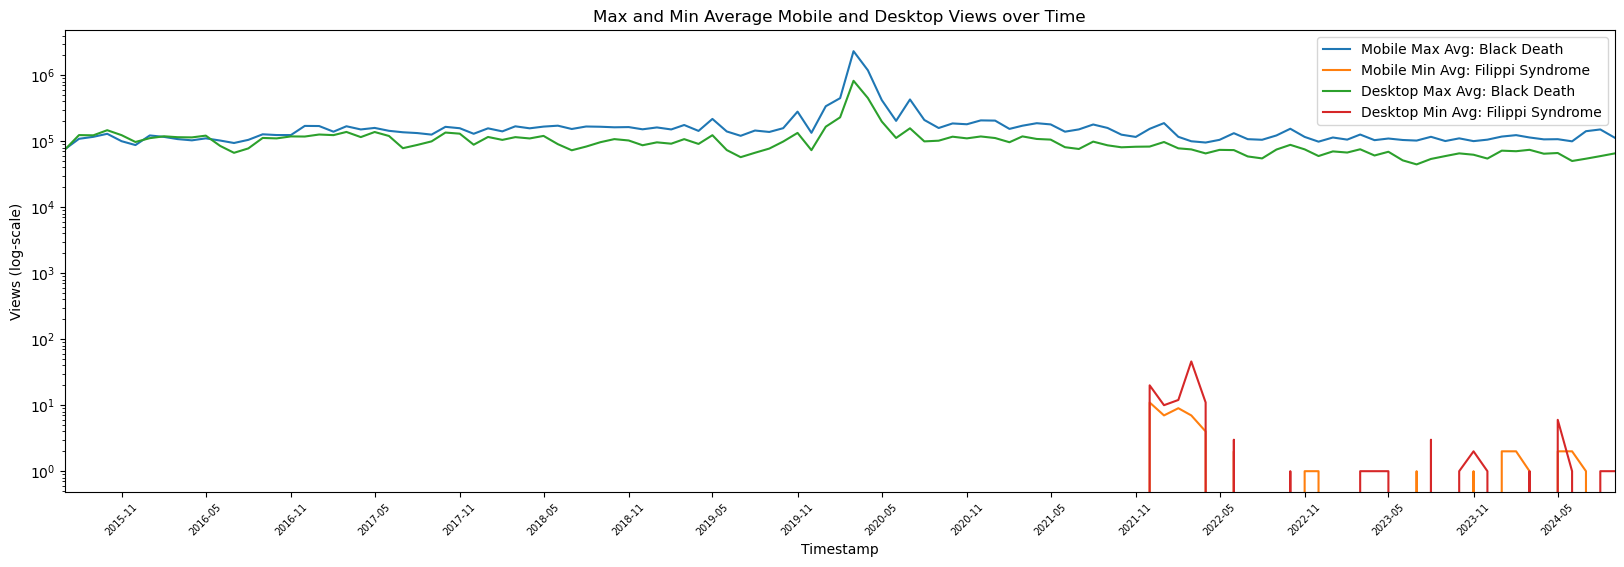

In [38]:
# Create Max and Min Average graph for mobile and desktop using graph_mobile_desktop_max_min function with mobile and desktop JSON files and start/end dates
graph_mobile_desktop_max_min('rare-disease_monthly_mobile_2015070100-2024093000.json', 'rare-disease_monthly_desktop_2015070100-2024093000.json',2015070100, 2024093000)

#### Top 10 Peak Page Views Analysis
Creates a graph containing time series for top 10 article pages by largest number page views at one timestamp (a peak in views) for desktop access and mobile access over the timeframe given for start and end timestamps, here it is the timeframe of the data, July, 2015 through September, 2024

In [27]:
def find_peak_articles(data):
    """
    Finds and returns the top 10 article pages by largest number page views at one timestamp
    (a peak in views) over the dataset.

    Args:
        data: A dictionary where keys are article names and values are lists of dictionaries,
                     each containing 'views' data for a specific timestamp, type dict.

    Returns:
        top_10: List of the top 10 article pages by largest number page views at one timestamp
                    (a peak in views) over the entire time series, type is list.
    """

    max_views_list = []  # List to store the maximum views for each article
    article_list = list(data.keys())  # List of article names

    # Loop through each article to find the peak views
    for article in data.keys():
        views_list = [request['views'] for request in data[article]]
        max_views_list.append(np.max(views_list))

    # Create a DataFrame with articles and their peak views
    data_df = pd.DataFrame({'article': article_list, 'max_views': max_views_list})

    # Sort the DataFrame by max_views where the largest value is the first row
    data_df_sorted = data_df.sort_values(by='max_views', ascending=False)

    # Get the top 10 articles with the highest peak views
    top_10 = list(data_df_sorted.head(10)['article'])

    return top_10 # Return list of top 10 article names


In [35]:
def graph_mobile_desktop_top_views(mobile_json_filepath, desktop_json_filepath, start_date, end_date):
    """
    Creates a graph showing the the top 10 article pages by largest number page views at one timestamp
    (a peak in views) over the entire time series for both mobile and desktop platforms over a specified
    time period. The mobile data is represented with solid lines and the desktop data is shown with
    dashed lines. The graph is saved as a PNG image.

    Args:
        mobile_json_filepath: The file path to the JSON file containing mobile view data, type str.
        desktop_json_filepath: The file path to the JSON file containing desktop view data, type str.
        start_date: The start date of the time range in the format 'YYYYMMDDHH', type str.
        end_date: The end date of the time range in the format 'YYYYMMDDHH', type str.

    Returns:
        None - the function saves the graph as 'top10_peak_views.png'.

    """

    # Load mobile and desktop data from the provided JSON file paths
    with open(mobile_json_filepath, 'r') as m_file:
        mobile_data = json.load(m_file)

    with open(desktop_json_filepath, 'r') as d_file:
        desktop_data = json.load(d_file)

    # Find top 10 articles with peak views for mobile and desktop platforms usisng find_peak_articles function
    m_top_10_names = find_peak_articles(mobile_data)
    d_top_10_names = find_peak_articles(desktop_data)

    # Create a list of monthly timestamps between start_date and end_date using generate_monthly_timestamp function from Chat GPT
    time_list = generate_monthly_timestamps(start_date, end_date)

    # Plot mobile top 10 articles with solid lines
    plt.figure(figsize=(20, 6))
    for name in m_top_10_names:
        # Create df with zero for all view counts for each timestamp
        graph_df = pd.DataFrame({
            'timestamp': time_list,
            'mobile_top10': [0] * len(time_list)
        })
        # Map number views to timestamp
        for request in mobile_data[name]:
            graph_df.loc[graph_df['timestamp'] == request['timestamp'], 'mobile_top10'] = request['views']
        # Convert timestamp to datetime type for better graphing
        graph_df['timestamp'] = pd.to_datetime(graph_df['timestamp'], format='%Y%m%d%H')
        plt.plot(graph_df['timestamp'], graph_df['mobile_top10'], label=f'Mobile: {name}')

    # Plot desktop top 10 articles with dashed lines
    for name in d_top_10_names:
        # Create df with zero for all view counts for each timestamp
        graph_df = pd.DataFrame({
            'timestamp': time_list,
            'desktop_top10': [0] * len(time_list)
        })
        # Map number views to timestamp
        for request in desktop_data[name]:
            graph_df.loc[graph_df['timestamp'] == request['timestamp'], 'desktop_top10'] = request['views']
        # Convert timestamp to datetime type for better graphing
        graph_df['timestamp'] = pd.to_datetime(graph_df['timestamp'], format='%Y%m%d%H')
        plt.plot(graph_df['timestamp'], graph_df['desktop_top10'], label=f'Desktop: {name}', linestyle='dashed')

    # Set plot largs
    plt.yscale('log')
    plt.xlim(graph_df['timestamp'].min(), graph_df['timestamp'].max())
    plt.xlabel('Timestamp')
    plt.ylabel('Views (log-scale)')
    plt.title('Top 10 Articles with Highest Peak Mobile and Desktop Views over Time')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=True)

    # Format the x-axis to show monthly ticks with function from Chat GPT
    format_monthly_ticks()

    # Save the plot as a PNG file
    plt.savefig('top10_peak_views.png', format='png', bbox_inches='tight')


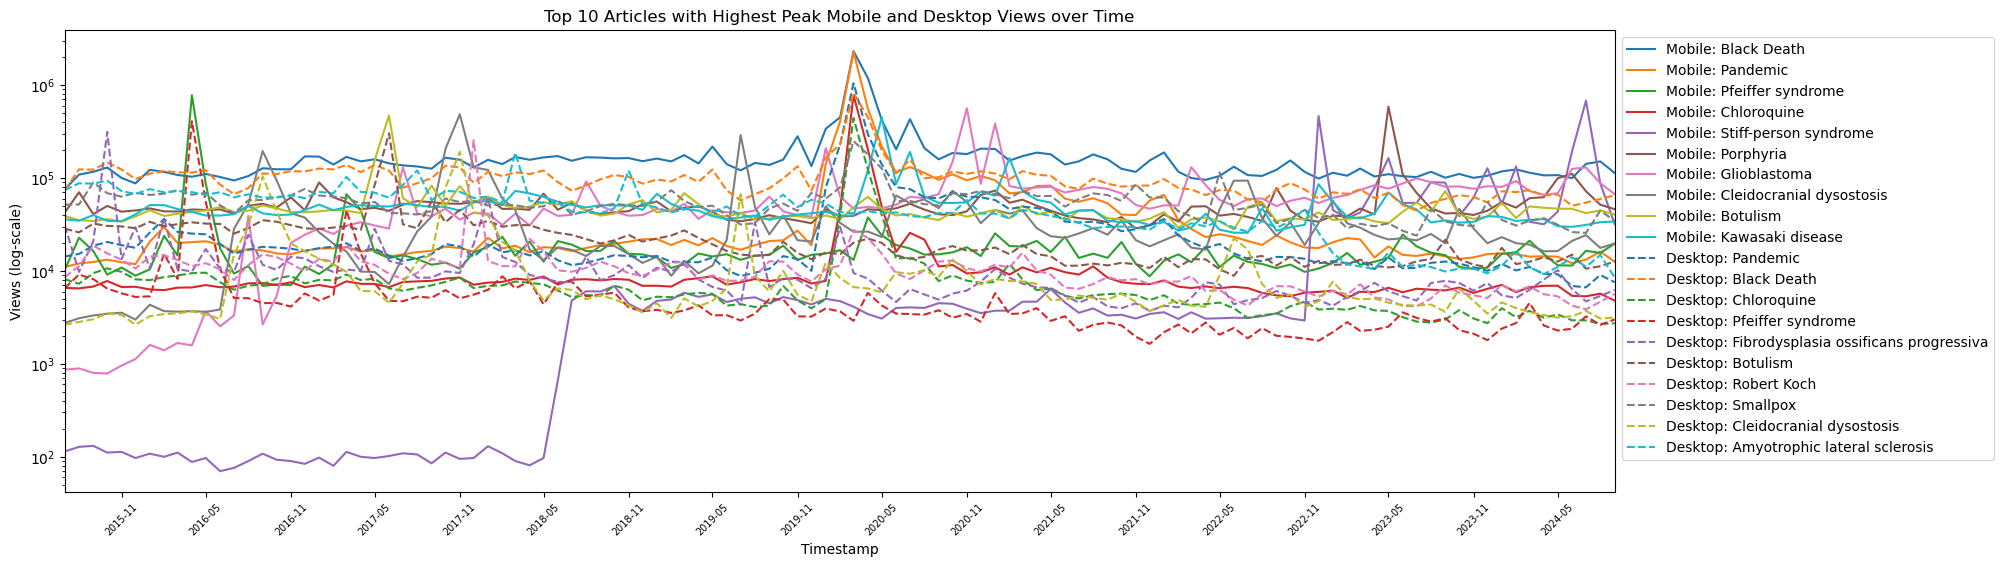

In [36]:
# Create top 10 peak graph for mobile and desktop using graph_mobile_desktop_top_views function with mobile and desktop JSON files and start/end dates
graph_mobile_desktop_top_views('rare-disease_monthly_mobile_2015070100-2024093000.json', 'rare-disease_monthly_desktop_2015070100-2024093000.json',2015070100, 2024093000)

#### Fewest Months of Data Analysis
Creates a graph containing time series for top 10 article pages that contain the fewest months of data for desktop access and mobile access over the timeframe given for start and end timestamps, here it is the timeframe of the data, July, 2015 through September, 2024

In [30]:
def find_least_month_articles(data):
    """
   Finds the top 10 articles with the least number of months of available data from the given dataset.
   Please note it takes the first 10 in the dataframe so there may be other articles with the same count that are not included

    Args:
        data: A dictionary where keys are article names and values are lists containing data entries for
                     each month, where each entry represents views or other relevant data for that month, dict type.

    Returns:
        least_10: A list of the top 10 articles with the least number of months of available data, list type.
    """

    months_list = []  # List to store the count of months of data available for each article
    article_list = list(data.keys())  # List of article names for dataframe

    # Loop through each article to count the months of available data
    for article in data.keys():
        months_list.append(len(data[article]))

    # Create a DataFrame with articles and their month counts
    data_df = pd.DataFrame({'article': article_list, 'months_count': months_list})

    # Sort the DataFrame by months_count in order so the least count is the first row
    data_df_sorted = data_df.sort_values(by='months_count', ascending=True)

    # Get the top 10 articles with the least months of data
    # NOTE: Does not account for a tie in month counts
    least_10 = list(data_df_sorted.head(10)['article'])

    return least_10 # Return list of article names with least number of months available data


In [44]:
def graph_mobile_desktop_least_months(mobile_json_filepath, desktop_json_filepath, start_date, end_date):
    """
    Create a graph showing the 10 articles with the least months of available data
    for both mobile and desktop platforms.

    Args:
        mobile_json_filepath: The file path to the JSON file containing mobile article data, type str.
        desktop_json_filepath: The file path to the JSON file containing desktop article data, typr str.
        start_date: The start date for the graph in 'YYYYMMDDHH' format, type str.
        end_date: The end date for the graph in 'YYYYMMDDHH' format, type str.

    Returns:
        None - the function saves the graph as '10_least_months.png'.

    """

    # Load mobile data from JSON file
    with open(mobile_json_filepath, 'r') as m_file:
        mobile_data = json.load(m_file)

    # Load desktop data from JSON file
    with open(desktop_json_filepath, 'r') as d_file:
        desktop_data = json.load(d_file)

    # Get the names of the top 10 articles with the least months of data for mobile and desktop ususing find_least_month_articles
    m_least_10_names = find_least_month_articles(mobile_data)
    d_least_10_names = find_least_month_articles(desktop_data)

    # Create a list of timestamps for the specified date range using Chat GPT function
    time_list = generate_monthly_timestamps(start_date, end_date)

    # Plot data for mobile access articles with the least months of data with solid lines
    plt.figure(figsize=(20, 6))


    for name in m_least_10_names:
        # Create df with zero for all view counts for each timestamp
        graph_df = pd.DataFrame({'timestamp': time_list,
                                 'mobile_least10': [0]*len(time_list)})
        # Map number views to timestamp
        for request in mobile_data[name]:
            graph_df.loc[graph_df['timestamp'] == request['timestamp'], 'mobile_least10'] = request['views']
        # Convert timestamp to datetime type for better graphing
        graph_df['timestamp'] = pd.to_datetime(graph_df['timestamp'], format='%Y%m%d%H')
        plt.plot(graph_df['timestamp'], graph_df['mobile_least10'], label=f'Mobile: {name}')

    # Plot data for desktop articles with the least months of data with dashed lines
    for name in d_least_10_names:
        # Create df with zero for all view counts for each timestamp
        graph_df = pd.DataFrame({'timestamp': time_list,
                                 'desktop_least10': [0]*len(time_list)})
        # Map number views to timestamp
        for request in desktop_data[name]:
            graph_df.loc[graph_df['timestamp'] == request['timestamp'], 'desktop_least10'] = request['views']
        # Convert timestamp to datetime type for better graphing
        graph_df['timestamp'] = pd.to_datetime(graph_df['timestamp'], format='%Y%m%d%H')
        plt.plot(graph_df['timestamp'], graph_df['desktop_least10'], label=f'Desktop: {name}', linestyle='dashed')

    # Set graph args
    plt.yscale('log')
    # Add filter to set beginning of graph where the number of views starts being non-zero
    filtered_df = graph_df[graph_df['desktop_least10'] != 0]
    plt.xlim(filtered_df['timestamp'].min(), graph_df['timestamp'].max())
    plt.xlabel('Timestamp')
    plt.ylabel('Views (log-scale)')
    plt.title('10 Articles with Least Months Data Mobile and Desktop Views over Time')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=True)

    # Format the x-axis ticks to show monthly using Chat GPT function
    format_monthly_ticks()

    # Save the generated plot as a PNG file
    plt.savefig('10_least_months.png', format='png', bbox_inches='tight')


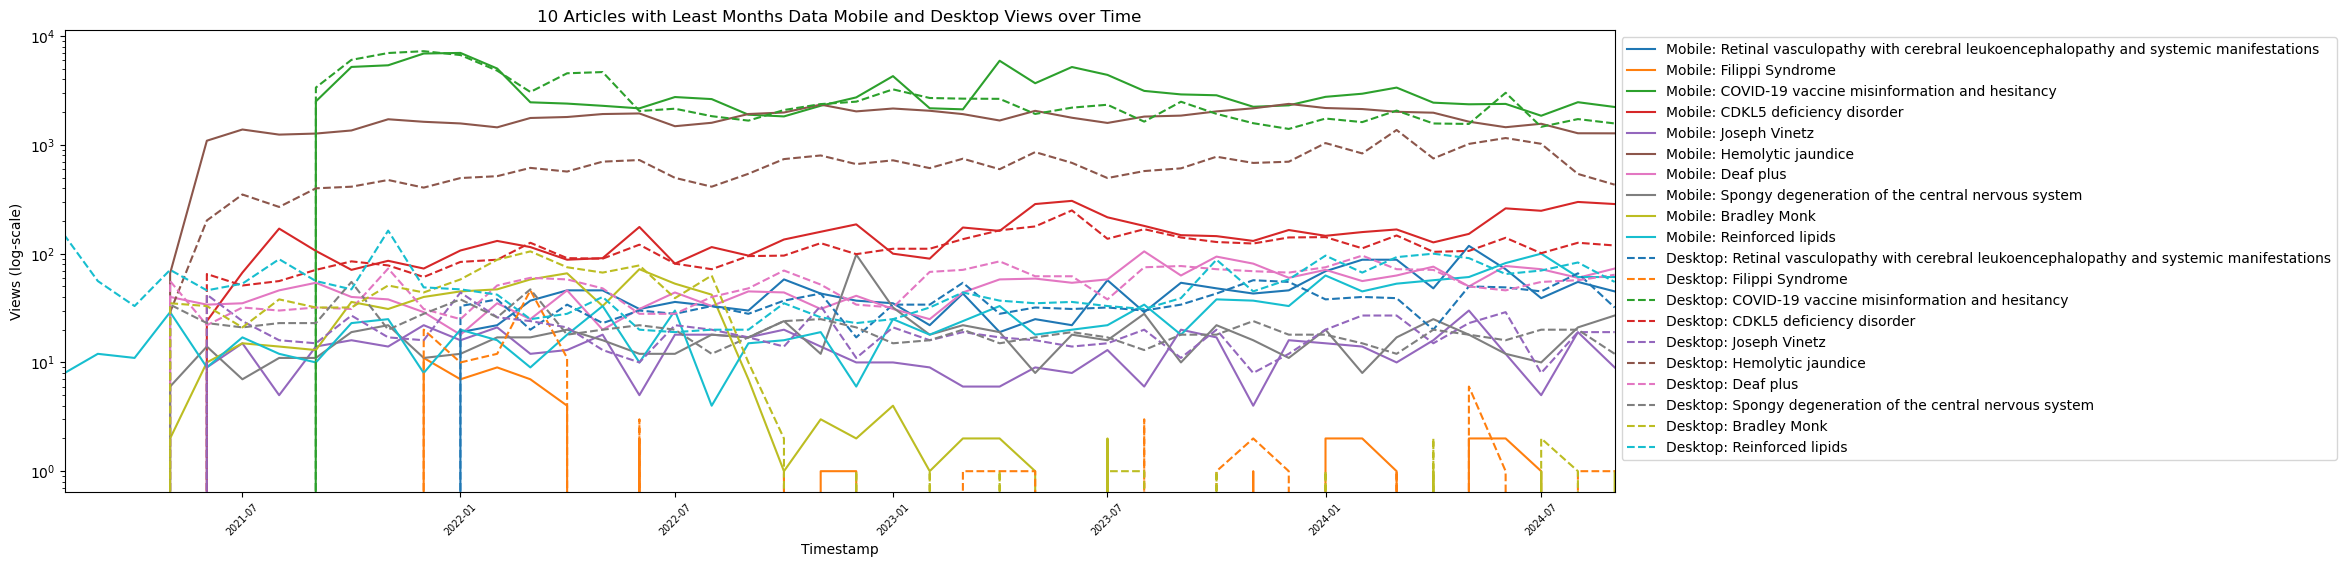

In [45]:
# Create graph for 10 articles with least number of months of data available for mobile and desktop using graph_mobile_desktop_least_months function with mobile and desktop JSON files and start/end dates
graph_mobile_desktop_least_months('rare-disease_monthly_mobile_2015070100-2024093000.json', 'rare-disease_monthly_desktop_2015070100-2024093000.json',2015070100, 2024093000)